# シングルパスプランジェネレーター
* 『LangChainとLangGraphによるRAG・AIエージェント実践入門（12章より)』
* 設定された目標を達成するための一連の具体的なステップを生成するパターン

<br>

以下の一連の処理を実装
* パッシブゴールクリエイターとプロンプト最適化による目標設定
* 設定された目標に対し、ワンショットモデルクエリとシングルパスプランジェネレーターにより、設定した目標をタスク分解
* タスク分解の結果作成されたタスクリクエストに基づいて各タスクを実行
* レスポンス最適化によって定義されたレスポンス仕様によるレポート出力

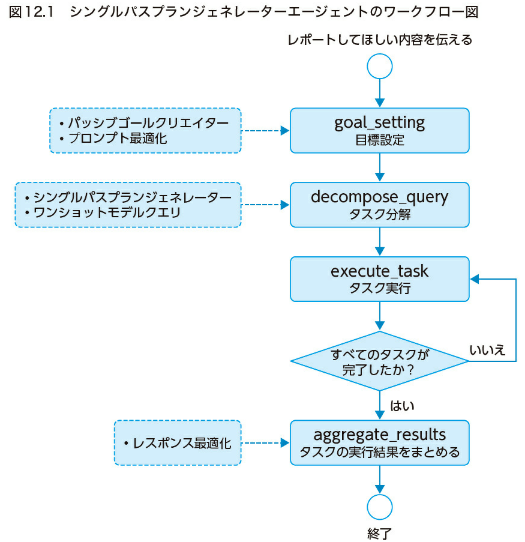

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/for_study_in_library/study_LangGraph/png/sppg.png")

ワークフローは、次の４つのノードにより構成
* `goal_setting`: 目標設定
* `decompose_query`: タスク分解
* `execute_task`: タスク実行
* `aggregate_results`: タスクの実行結果をまとめる

In [1]:
# !pip install langchain-core==0.3.0 langchain-community==0.3.0 \
# langgraph==0.2.22 langchain-openai==0.2.0 langchain-anthropic==0.2.0 \
# numpy==1.26.4 faiss-cpu==1.8.0.post1 \
# pydantic-settings==2.5.2 retry==0.9.2 decorator==4.4.2

In [2]:
# !pip install "pydantic<2.11"  # 例: 2.10.6 エラー回避用

In [2]:
from dotenv import load_dotenv
load_dotenv()

In [3]:
# import os

# os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
# os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT
# os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [8]:
import operator
from datetime import datetime
from typing import Annotated, Any

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import create_react_agent
from agent_tools.passive_goal_creator.main import Goal, PassiveGoalCreator
from agent_tools.prompt_optimizer.main import OptimizedGoal, PromptOptimizer
from pydantic import BaseModel, Field
from agent_tools.response_optimizer.main import ResponseOptimizer

## ステート設計

In [9]:
class DecomposedTasks(BaseModel):
    values: list[str] = Field(
        default_factory=list,
        min_items=3,
        max_items=5,
        description="3~5個に分解されたタスク",
    )
# 最小要素数(min_items)、最大要素数(max_items)を含めることで生成されるリストの要素数をコントロール


class SinglePathPlanGenerationState(BaseModel):
    query: str = Field(..., description="ユーザーが入力したクエリ")
    optimized_goal: str = Field(default="", description="最適化された目標")
    optimized_response: str = Field(
        default="", description="最適化されたレスポンス定義"
    )
    tasks: list[str] = Field(default_factory=list, description="実行するタスクのリスト")
    current_task_index: int = Field(default=0, description="現在実行中のタスクの番号")
    results: Annotated[list[str], operator.add] = Field(
        default_factory=list, description="実行済みタスクの結果リスト"
    )
    final_output: str = Field(default="", description="最終的な出力結果")

モデルの定義内容  
* query:
    * ユーザーからの入力を保持
* optimized_goal:
    * ユーザーからの入力を詳細化／最適化した目標を保持
* optimized_response:
    * 詳細化／最適化した目標に対して適切なレスポンスを保持
* tasks:
    * 詳細化／最適化した目標をもとにタスク分解した結果を保持
* current_task_index:
    * 現在何番目のタスクに取り組んでいるかを保持
* results:
    * 各タスクの実行結果を保持
* final_output:
    * aggregate_resultsノードの実行結果を保持

### `decompose_query`ノード：タスク分解

In [10]:
class QueryDecomposer:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.current_date = datetime.now().strftime("%Y-%m-%d")

    def run(self, query: str) -> DecomposedTasks:
        prompt = ChatPromptTemplate.from_template(
            f"CURRENT_DATE: {self.current_date}\n"
            "-----\n"
            "タスク: 与えられた目標を具体的で実行可能なタスクに分解してください。\n"
            "要件:\n"
            "1. 以下の行動だけで目標を達成すること。決して指定された以外の行動をとらないこと。\n"
            "   - インターネットを利用して、目標を達成するための調査を行う。\n"
            "2. 各タスクは具体的かつ詳細に記載されており、単独で実行ならびに検証可能な情報を含めること。一切抽象的な表現を含まないこと。\n"
            "3. タスクは実行可能な順序でリスト化すること。\n"
            "4. タスクは日本語で出力すること。\n"
            "目標: {query}"
        )
        chain = prompt | self.llm.with_structured_output(DecomposedTasks)
        return chain.invoke({"query": query})

ここでは、ワンショットモデルクエリでプランを生成。  
　目標には、「来月まで」といった時間的要素が含まれる可能背があるため、具体的な時間軸を考慮したタスク分解ができるよう、現在時刻をタスク分解のプロンプトに設定。  
また、AIエージェントの動作に制約をつけるため、詳細な要件も設定。要件が設定されていない場合、「ステークホルダーにヒアリングする」といったAIエージェントでは実行不可能なタスクも、タスク分解結果に含まれてしまうため注意が必要。  

<br>
decomposed_queryノードでは、`QueryDecomposer`でタスク分解を実行した結果を受け取り、ステートの`tasks`フィールドを更新する。

```python
def _decompose_query(self, state: SinglePathPlanGenerationState) -> dict[str, Any]:
    decomposed_tasks: DecomposedTasks = self.query_decomposer.run(
        query=state.optimized_goal
    )

    return { "tasks": decomposed_tasks.values}
```

### `execute_task`ノード：タスク実行
　decomposed_queryノードで得られたtasksフィールドに保存されているタスクを１つずつ取り出し、`TaskExecutor`クラスでその目標について実行した結果を、`results`フィールドに実行悔過として保存する

In [17]:
class TaskExecutor:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.tools = [TavilySearchResults(max_results=3)]

    def run(self, task: str) -> str:
        agent = create_react_agent(self.llm, self.tools)
        result = agent.invoke(
            {
                "messages": [
                    (
                        "human",
                        (
                            "次のタスクを実行し、詳細な回答を提供してください。\n\n"
                            f"タスク: {task}\n\n"
                            "要件:\n"
                            "1. 必要に応じて提供されたツールを使用してください。\n"
                            "2. 実行は徹底的かつ包括的に行ってください。\n"
                            "3. 可能な限り具体的な事実やデータを提供してください。\n"
                            "4. 発見した内容を明確に要約してください。\n"
                        ),
                    )
                ]
            }
        )
        return result["messages"][-1].content

`TaskExcutor`を呼び出して`results`フィールドに保存する処理  

```python
def _execute_task(self, state: SinglePathPlanGenerationState) -> dict[str, Any]:
    current_task = state.tasks[state.current_task_index]
    result = self.task_executor.run(task=current_task)
    return {
        "results": [result],
        "current_task_index": state.current_task_index + 1,
    }
```

* `execute_task`ノードでどのタスクを実行すべきかは、`current_task_index`フィールドの値で把握
* `current_task_index`フィールドの値は`execute_task`ノードを実行するたびにインクリメント
* 生成されたタスクについてすべて処理が完了すると、次の条件付きエッジにより`aggregate_results`ノードへ処理が移行する。

```python
graph.add_conditional_edges(
    "execute_task",
    lambda state: state.current_task_index < len(state.tasks.goals),
    {True: "execute_task", False: "aggregate_results"},
)
```

### `aggregate_results`ノード：タスクの実行結果をまとめる
* `ResultAggregator`クラスのrun関数には、詳細化／最適化した目標、最適化されたレスポンス仕様、AIエージェントによるタスクの実行結果をそれぞれ入力している
* プロンプトをそのまま渡すと、事前にレスポンス最適化によりレスポンス仕様を定めた詳細なプロンプトが作成される


In [11]:
class ResultAggregator:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, query: str, response_definition: str, results: list[str]) -> str:
        prompt = ChatPromptTemplate.from_template(
            "与えられた目標:\n{query}\n\n"
            "調査結果:\n{results}\n\n"
            "与えられた目標に対し、調査結果を用いて、以下の指示に基づいてレスポンスを生成してください。\n"
            "{response_definition}"
        )
        results_str = "\n\n".join(
            f"Info {i+1}:\n{result}" for i, result in enumerate(results)
        )
        chain = prompt | self.llm | StrOutputParser()
        return chain.invoke(
            {
                "query": query,
                "results": results_str,
                "response_definition": response_definition,
            }
        )

## グラフ作成、ノード追加、エッジ設定

In [31]:
class SinglePathPlanGeneration:
    def __init__(self, llm: ChatOpenAI):
        self.passive_goal_creator = PassiveGoalCreator(llm=llm)
        self.prompt_optimizer = PromptOptimizer(llm=llm)
        self.response_optimizer = ResponseOptimizer(llm=llm)
        self.query_decomposer = QueryDecomposer(llm=llm)
        self.task_executor = TaskExecutor(llm=llm)
        self.result_aggregator = ResultAggregator(llm=llm)
        self.graph = self._create_graph()

    def _create_graph(self) -> StateGraph:
        graph = StateGraph(SinglePathPlanGenerationState)
        graph.add_node("goal_setting", self._goal_setting)
        graph.add_node("decompose_query", self._decompose_query)
        graph.add_node("execute_task", self._execute_task)
        graph.add_node("aggregate_results", self._aggregate_results)
        graph.set_entry_point("goal_setting")
        graph.add_edge("goal_setting", "decompose_query")
        graph.add_edge("decompose_query", "execute_task")
        graph.add_conditional_edges(
            "execute_task",
            lambda state: state.current_task_index < len(state.tasks),
            {True: "execute_task", False: "aggregate_results"},
        )
        graph.add_edge("aggregate_results", END)
        return graph.compile()

    def _goal_setting(self, state: SinglePathPlanGenerationState) -> dict[str, Any]:
        # プロンプト最適化
        goal: Goal = self.passive_goal_creator.run(query=state.query)
        optimized_goal: OptimizedGoal = self.prompt_optimizer.run(query=goal.text)
        # レスポンス最適化
        optimized_response: str = self.response_optimizer.run(query=optimized_goal.text)
        return {
            "optimized_goal": optimized_goal.text,
            "optimized_response": optimized_response,
        }

    def _decompose_query(self, state: SinglePathPlanGenerationState) -> dict[str, Any]:
        decomposed_tasks: DecomposedTasks = self.query_decomposer.run(
            query=state.optimized_goal
        )
        return {"tasks": decomposed_tasks.values}

    def _execute_task(self, state: SinglePathPlanGenerationState) -> dict[str, Any]:
        current_task = state.tasks[state.current_task_index]
        result = self.task_executor.run(task=current_task)
        return {
            "results": [result],
            "current_task_index": state.current_task_index + 1,
        }

    def _aggregate_results(
        self, state: SinglePathPlanGenerationState
    ) -> dict[str, Any]:
        final_output = self.result_aggregator.run(
            query=state.optimized_goal,
            response_definition=state.optimized_response,
            results=state.results,
        )
        return {"final_output": final_output}

    def run(self, query: str) -> str:
        initial_state = SinglePathPlanGenerationState(query=query)
        final_state = self.graph.invoke(initial_state, {"recursion_limit": 1000})

        # debug用
        print("ステートの中身：")
        pprint(dict(final_state))
        print("\n\n")

        return final_state.get("final_output", "Failed to generate a final response.")

In [32]:
query = "カレーライスの作り方"

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

agent = SinglePathPlanGeneration(llm=llm)

result = agent.run(query)

pprint(result)

ステートの中身：
{'current_task_index': 5,
 'final_output': 'カレーライスの作り方\n'
                 '\n'
                 '### 必要な材料:\n'
                 '- 鶏もも肉: 200g\n'
                 '- じゃがいも: 1個\n'
                 '- にんじん: 1本\n'
                 '- 玉ねぎ: 1個\n'
                 '- おろししょうが: 小さじ1\n'
                 '- 市販のカレールウ: 1/2箱\n'
                 '- サラダ油: 大さじ1\n'
                 '- 水: 400ml\n'
                 '\n'
                 '### 調理手順:\n'
                 '1. **下ごしらえ**\n'
                 '   - じゃがいもは皮をむいて一口大に切り、水に5分ほどさらして水気を切ります。\n'
                 '   - 玉ねぎは薄切りにします。\n'
                 '   - にんじんは乱切りにします。\n'
                 '   - 鶏肉は一口大に切ります。\n'
                 '\n'
                 '2. **炒める**\n'
                 '   - 鍋にサラダ油を入れて中火で熱し、鶏肉とおろししょうがを入れて肉の色が変わるまで炒めます。\n'
                 '   - 玉ねぎを加えてしんなりするまで炒め、にんじん、じゃがいもを加えて油がまわるまで炒めます。\n'
                 '\n'
                 '3. **煮る**\n'
                 '   - 水を加え、煮立ったらふたをして弱火で10分煮ます。\n'
                 '\n'
                 